In [5]:
pip install scikit-learn matplotlib pandas pyarrow networkx matplotlib  


Note: you may need to restart the kernel to use updated packages.


## 1 Determine cluster numbers using elbow method.

[]


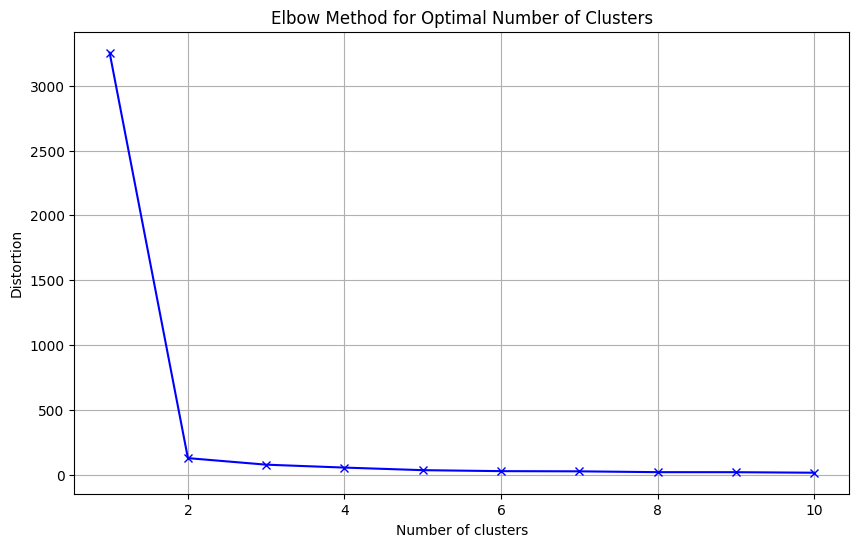

In [29]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt


G = nx.read_graphml("graph.graphml")
# Load the embeddings from the .npy file
embeddings = np.load("gnn_embeddings.npy")

# Calculate distortion for different numbers of clusters
distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

## 2 Clustering and Embeddings  Visualization in 2D

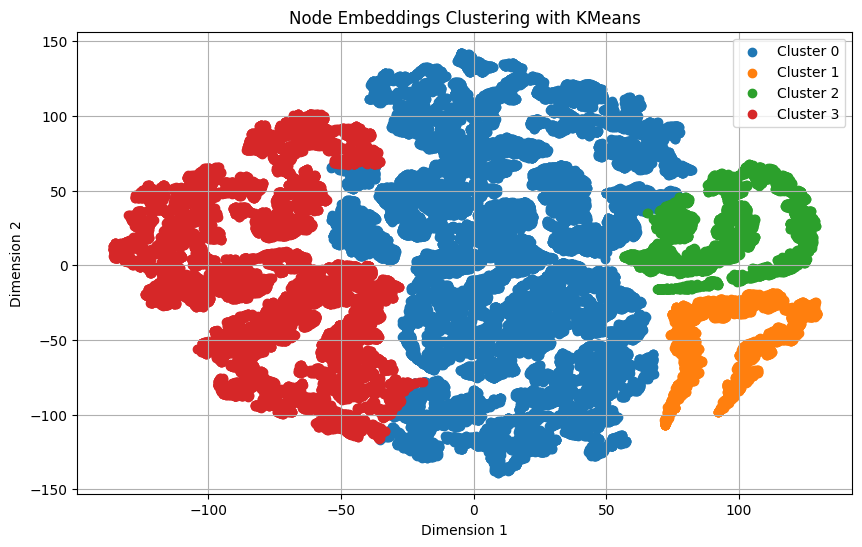

In [30]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define KMeans parameters
num_clusters = 4 # Optimal number of clusters

# Fit KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Reduce the dimensionality of the embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
for cluster in unique_labels:
    cluster_points = embeddings_2d[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Node Embeddings Clustering with KMeans")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Save the labels for future reference
np.save("kmeans_labels.npy", labels)

## 3. Cluster Analysys

In [32]:
# Function to summarize cluster characteristics
def summarize_cluster(cluster_nodes, G):
    cluster_summary = {}
    
    # Node Features
    node_types = [G.nodes[node]['Node_Type'] for node in cluster_nodes if 'Node_Type' in G.nodes[node]]
    node_count = len(cluster_nodes)
    node_type_distribution = {ntype: node_types.count(ntype) for ntype in set(node_types)}
    
    # Edge Features
    edge_frequencies = []
    edge_total_amounts = []
    for node in cluster_nodes:
        for neighbor in G.neighbors(node):
            if neighbor in cluster_nodes and 'Frequency' in G.edges[node, neighbor] and 'Total_Amount' in G.edges[node, neighbor]:
                edge_frequencies.append(G.edges[node, neighbor]['Frequency'])
                edge_total_amounts.append(G.edges[node, neighbor]['Total_Amount'])
    
    if edge_frequencies:
        mean_edge_frequency = np.mean(edge_frequencies)
        std_edge_frequency = np.std(edge_frequencies)
    else:
        mean_edge_frequency = std_edge_frequency = None
    
    if edge_total_amounts:
        mean_total_amount = np.mean(edge_total_amounts)
        std_total_amount = np.std(edge_total_amounts)
    else:
        mean_total_amount = std_total_amount = None
    
    # Cluster Connectivity
    subgraph = G.subgraph(cluster_nodes)
    avg_degree = sum(dict(subgraph.degree()).values()) / float(node_count)
    density = nx.density(subgraph)
    
    # Summarize
    cluster_summary['node_count'] = node_count
    cluster_summary['node_type_distribution'] = node_type_distribution
    cluster_summary['mean_edge_frequency'] = mean_edge_frequency
    cluster_summary['std_edge_frequency'] = std_edge_frequency
    cluster_summary['mean_total_amount'] = mean_total_amount
    cluster_summary['std_total_amount'] = std_total_amount
    cluster_summary['avg_degree'] = avg_degree
    cluster_summary['density'] = density
    
    return cluster_summary

# Analyze each cluster
clustered_nodes = {i: [] for i in range(num_clusters)}
for node, label in zip(list(G.nodes), labels):
    clustered_nodes[label].append(node)

for cluster, nodes in clustered_nodes.items():
    summary = summarize_cluster(nodes, G)
    print(f"Cluster {cluster} Summary:")
    print(f"  Node Count: {summary['node_count']}")
    print(f"  Node Type Distribution: {summary['node_type_distribution']}")
    if summary['mean_edge_frequency'] is not None:
        print(f"  Mean Edge Frequency: {summary['mean_edge_frequency']}")
        print(f"  Std Edge Frequency: {summary['std_edge_frequency']}")
    if summary['mean_total_amount'] is not None:
        print(f"  Mean Total Amount: {summary['mean_total_amount']}")
        print(f"  Std Total Amount: {summary['std_total_amount']}")
    print(f"  Average Degree: {summary['avg_degree']}")
    print(f"  Density: {summary['density']}")

Cluster 0 Summary:
  Node Count: 28740
  Node Type Distribution: {'Customer': 28738, 'Transaction_Type': 2}
  Mean Edge Frequency: 2.794868416718817
  Std Edge Frequency: 4.635476962341747
  Mean Total Amount: 1453.9998023780508
  Std Total Amount: 5394.490178856535
  Average Degree: 2.112804453723034
  Density: 7.351697879964627e-05
Cluster 1 Summary:
  Node Count: 3175
  Node Type Distribution: {'Customer': 3174, 'Transaction_Type': 1}
  Mean Edge Frequency: 1.0053560176433523
  Std Edge Frequency: 0.11627074917652987
  Mean Total Amount: 684.5069313169503
  Std Total Amount: 966.0133689716629
  Average Degree: 1.9993700787401574
  Density: 0.0006299212598425197
Cluster 2 Summary:
  Node Count: 4455
  Node Type Distribution: {'Customer': 4455}
  Average Degree: 0.0
  Density: 0
Cluster 3 Summary:
  Node Count: 14998
  Node Type Distribution: {'Customer': 14998}
  Average Degree: 0.0
  Density: 0
